In [1]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
labelsPath = os.path.join('dataset/yolo.names')
LABELS = open(labelsPath).read().strip().split('\n')

In [4]:
LABELS

['player', 'ball']

In [5]:
def display_img(img, cmap=None):
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap)
    
rect_colors = {
  'player': (255, 46, 42),
  'ball': (36, 52, 255),
}

def predict(image):
    
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.1
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            label = LABELS[classIDs[i]]
            color = rect_colors[label]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
#             text = "{}".format(LABELS[classIDs[i]], confidences[i])
#             cv2.putText(image, text, (x +15, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
#                 1, color, 2)
            
    return image

In [6]:
weightsPath = os.path.join('yolov3_my2_6000.weights')
configPath = os.path.join('cfg/yolov3_my2.cfg')
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

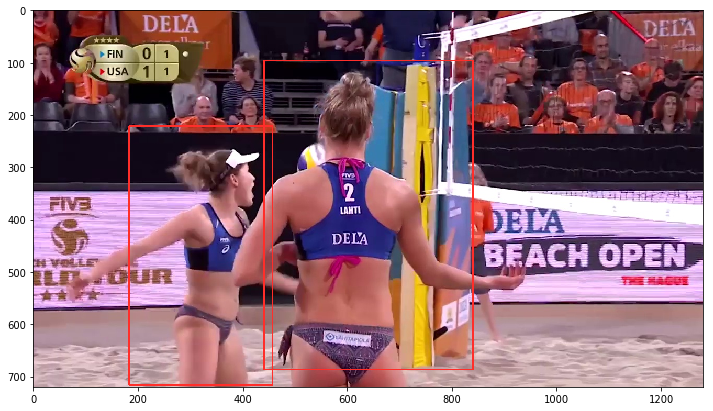

In [25]:
img = cv2.imread("dataset/images/wb5-frame7800.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display_img(predict(img))

In [29]:
cap = cv2.VideoCapture('./videos/USA vs Brazil - Women-s Beach Volleyball - Highlights Nanjing 2014 Youth Olympic Games.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_size = (width, height)
number_frame = int(cap.get(cv2.CAP_PROP_FPS))

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('detection.mp4',fourcc, number_frame, video_size)

while True:
    ret, frame = cap.read()
    
    if ret:        
        frame = cv2.resize(frame, video_size)
        frame = predict(frame)
        cv2.imshow("image", frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xff == ord("q"):
            break
    else:
        break
        
cap.release()   
out.release()
cv2.destroyAllWindows()